<a href="https://colab.research.google.com/github/karenfridman/INT-2025/blob/main/Second_task_Karen_Fridman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info
Data set: January Flight Delay Prediction

Downloaded from: https://www.kaggle.com/datasets/divyansh22/flight-delay-prediction?select=Jan_2019_ontime.csv

About the file: This file contains all the flights starting from 1st January 2019 till 31st January 2019. There are around 400,000 rows in this file and 21 feature columns indicating the features of the flight including information about origin airport, destination airport, airplane information, departure time and arrival time.

In [5]:
import kagglehub
import os
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix,classification_report,recall_score,confusion_matrix,mean_squared_error, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score,ShuffleSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Functions

In [6]:
def delayed_graph(df, bound, col, color):
  if bound == 'dep':
    delayed_flights = df[df['DEP_DEL15'] == 1]
  elif bound == 'arr':
    delayed_flights = df[df['ARR_DEL15'] == 1]

  delays_by = delayed_flights[col].value_counts()
  total_by = df[col].value_counts()
  proportion_by = (delays_by / total_by).fillna(0)

  delay_stats = pd.DataFrame({
        'delays': delays_by,
        'total': total_by,
        'proportion': proportion_by
    }).fillna(0)

  delay_stats = delay_stats.sort_values('delays', ascending=False)

  if col in ['ORIGIN', 'DEST']:
    delay_stats = delay_stats.head(20)

  x = np.arange(len(delay_stats))

  fig, ax1 = plt.subplots(figsize=(14, 6))

    # Bar plot for raw delay counts
  width = 0.4
  ax1.bar(x - width/2, delay_stats['delays'], width=width, color=color, label='Delayed Flights')
  ax1.set_ylabel('Number of Delays', color=color)
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.set_xticks(x)
  ax1.set_xticklabels(delay_stats.index, rotation=45, ha='right')

    # Secondary axis for proportion
  ax2 = ax1.twinx()
  ax2.bar(x + width/2, delay_stats['proportion'], width=width, color='orange', label='Proportion of Delays')
  ax2.set_ylabel('Proportion of Delays', color='orange')
  ax2.tick_params(axis='y', labelcolor='orange')

    # Title and layout
  plt.title(f'Delayed {bound.upper()} Flights by {col}: Counts and Proportions')
  ax1.grid(axis='y', linestyle='--', alpha=0.5)
  fig.tight_layout()

    # Optional legend combining both bars
  lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
  lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
  ax1.legend(lines, labels, loc='upper right')

  plt.show()

  return delay_stats

In [7]:
def encode_categories(df, features):
    lb_make = LabelEncoder()
    for i in range(len(features)):
        df[features[i]] = lb_make.fit_transform(df[features[i]])

In [21]:
def models_result(X_train, X_test, y_train, y_test):
  models = []
  models.append(('LogisticRegression', LogisticRegression()))
  models.append(('RandomForest', RandomForestClassifier()))
  models.append(('Decision Tree', DecisionTreeClassifier()))
  models.append(('KNN', KNeighborsClassifier(n_neighbors = 5)))
  models.append(('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')))

  for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'{name} Confusion Matrix')
    plt.show()

In [8]:
#Download files from kaggle
path = kagglehub.dataset_download("divyansh22/flight-delay-prediction")

print("Path to dataset files:", path)
print(os.listdir(path))

Path to dataset files: /kaggle/input/flight-delay-prediction
['Jan_2019_ontime.csv', 'Jan_2020_ontime.csv']


In [9]:
file_path_2019 = os.path.join(path, "Jan_2019_ontime.csv")
flights_2019 = pd.read_csv(file_path_2019)
file_path_2020 = os.path.join(path, "Jan_2020_ontime.csv")
flights_2020 = pd.read_csv(file_path_2020)

I will use the data from January 2019 to train and data from Jan 2020 to test the model

# EDA
Questions we want to answer from the data!



*   Satistics fo the dataset
*   The concentration of delay and non-delay both on departure and on arrival?
*   The proportion of delayed flights that were diverted?
*   Are delays due to day_of_week and day_of_month?
*   The concentration of delay's by 'DEP_TIME_BLK'?
*   Which airport in Origin stands out in delays?
*   Which airport in Destination stands out in delays?

In [107]:
flights_2019.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,10397,1039707,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,11193,1119302,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,11193,1119302,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,10397,1039707,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,11778,1177801,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


In [108]:
flights_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583985 entries, 0 to 583984
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   DAY_OF_MONTH           583985 non-null  int64  
 1   DAY_OF_WEEK            583985 non-null  int64  
 2   OP_UNIQUE_CARRIER      583985 non-null  object 
 3   OP_CARRIER_AIRLINE_ID  583985 non-null  int64  
 4   OP_CARRIER             583985 non-null  object 
 5   TAIL_NUM               581442 non-null  object 
 6   OP_CARRIER_FL_NUM      583985 non-null  int64  
 7   ORIGIN_AIRPORT_ID      583985 non-null  int64  
 8   ORIGIN_AIRPORT_SEQ_ID  583985 non-null  int64  
 9   ORIGIN                 583985 non-null  object 
 10  DEST_AIRPORT_ID        583985 non-null  int64  
 11  DEST_AIRPORT_SEQ_ID    583985 non-null  int64  
 12  DEST                   583985 non-null  object 
 13  DEP_TIME               567633 non-null  float64
 14  DEP_DEL15              567630 non-nu

In [109]:
unique_counts = flights_2019.nunique()

print(unique_counts)

DAY_OF_MONTH               31
DAY_OF_WEEK                 7
OP_UNIQUE_CARRIER          17
OP_CARRIER_AIRLINE_ID      17
OP_CARRIER                 17
TAIL_NUM                 5446
OP_CARRIER_FL_NUM        6839
ORIGIN_AIRPORT_ID         346
ORIGIN_AIRPORT_SEQ_ID     346
ORIGIN                    346
DEST_AIRPORT_ID           346
DEST_AIRPORT_SEQ_ID       346
DEST                      346
DEP_TIME                 1438
DEP_DEL15                   2
DEP_TIME_BLK               19
ARR_TIME                 1440
ARR_DEL15                   2
CANCELLED                   2
DIVERTED                    2
DISTANCE                 1451
Unnamed: 21                 0
dtype: int64


In [110]:
for col in flights_2019.columns:
    num_unique = flights_2019[col].nunique()
    if num_unique < 4:
        flights_2019[col] = flights_2019[col].astype('category')

flights_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583985 entries, 0 to 583984
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   DAY_OF_MONTH           583985 non-null  int64   
 1   DAY_OF_WEEK            583985 non-null  int64   
 2   OP_UNIQUE_CARRIER      583985 non-null  object  
 3   OP_CARRIER_AIRLINE_ID  583985 non-null  int64   
 4   OP_CARRIER             583985 non-null  object  
 5   TAIL_NUM               581442 non-null  object  
 6   OP_CARRIER_FL_NUM      583985 non-null  int64   
 7   ORIGIN_AIRPORT_ID      583985 non-null  int64   
 8   ORIGIN_AIRPORT_SEQ_ID  583985 non-null  int64   
 9   ORIGIN                 583985 non-null  object  
 10  DEST_AIRPORT_ID        583985 non-null  int64   
 11  DEST_AIRPORT_SEQ_ID    583985 non-null  int64   
 12  DEST                   583985 non-null  object  
 13  DEP_TIME               567633 non-null  float64 
 14  DEP_DEL15           

In [111]:
duplicates = flights_2019.duplicated()
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 0


In [112]:
flights_2019.describe().T

,count,mean,std,min,25%,50%,75%,max
DAY_OF_MONTH,583985.0,1.596009e+01,8.987942,1.0,8.0,16.0,24.0,31.0
DAY_OF_WEEK,583985.0,3.835626e+00,1.921899,1.0,2.0,4.0,5.0,7.0
OP_CARRIER_AIRLINE_ID,583985.0,1.998321e+04,377.724638,19393.0,19790.0,19977.0,20368.0,20452.0
OP_CARRIER_FL_NUM,583985.0,2.537869e+03,1821.736145,1.0,979.0,2114.0,3902.0,7439.0
ORIGIN_AIRPORT_ID,583985.0,1.265970e+04,1519.405493,10135.0,11292.0,12889.0,13931.0,16218.0
ORIGIN_AIRPORT_SEQ_ID,583985.0,1.265974e+06,151940.299913,1013505.0,1129202.0,1288903.0,1393102.0,1621802.0
DEST_AIRPORT_ID,583985.0,1.265947e+04,1519.336466,10135.0,11292.0,12889.0,13931.0,16218.0
DEST_AIRPORT_SEQ_ID,583985.0,1.265951e+06,151933.397101,1013505.0,1129202.0,1288903.0,1393102.0,1621802.0
DEP_TIME,567633.0,1.331958e+03,495.404020,1.0,921.0,1328.0,1738.0,2400.0
ARR_TIME,566924.0,1.484316e+03,523.162855,1.0,1104.0,1517.0,1919.0,2400.0


<Axes: >

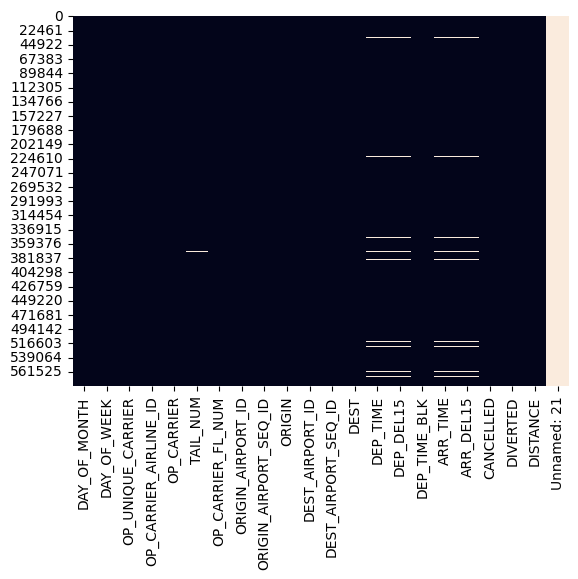

In [113]:
sns.heatmap(flights_2019.isnull(), cbar=False)

In [114]:
missing_count = flights_2019.isnull().sum()
missing_percentage = (missing_count / len(flights_2019)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_count, 'Missing Percentage': missing_percentage})
missing_df = missing_df[missing_percentage > 0]
print(missing_df.sort_values(by='Missing Percentage', ascending=False))

             Missing Count  Missing Percentage
Unnamed: 21         583985          100.000000
ARR_DEL15            18022            3.086038
ARR_TIME             17061            2.921479
DEP_DEL15            16355            2.800586
DEP_TIME             16352            2.800072
TAIL_NUM              2543            0.435456


In [115]:
flights_2019.describe().T

,count,mean,std,min,25%,50%,75%,max
DAY_OF_MONTH,583985.0,1.596009e+01,8.987942,1.0,8.0,16.0,24.0,31.0
DAY_OF_WEEK,583985.0,3.835626e+00,1.921899,1.0,2.0,4.0,5.0,7.0
OP_CARRIER_AIRLINE_ID,583985.0,1.998321e+04,377.724638,19393.0,19790.0,19977.0,20368.0,20452.0
OP_CARRIER_FL_NUM,583985.0,2.537869e+03,1821.736145,1.0,979.0,2114.0,3902.0,7439.0
ORIGIN_AIRPORT_ID,583985.0,1.265970e+04,1519.405493,10135.0,11292.0,12889.0,13931.0,16218.0
ORIGIN_AIRPORT_SEQ_ID,583985.0,1.265974e+06,151940.299913,1013505.0,1129202.0,1288903.0,1393102.0,1621802.0
DEST_AIRPORT_ID,583985.0,1.265947e+04,1519.336466,10135.0,11292.0,12889.0,13931.0,16218.0
DEST_AIRPORT_SEQ_ID,583985.0,1.265951e+06,151933.397101,1013505.0,1129202.0,1288903.0,1393102.0,1621802.0
DEP_TIME,567633.0,1.331958e+03,495.404020,1.0,921.0,1328.0,1738.0,2400.0
ARR_TIME,566924.0,1.484316e+03,523.162855,1.0,1104.0,1517.0,1919.0,2400.0


In [116]:
flights_2019.describe(include=['object', 'string', 'category']).T

,count,unique,top,freq
OP_UNIQUE_CARRIER,583985,17,WN,111312
OP_CARRIER,583985,17,WN,111312
TAIL_NUM,581442,5446,N488HA,361
ORIGIN,583985,346,ATL,31155
DEST,583985,346,ATL,31151
DEP_DEL15,567630.0,2.0,0.0,468703.0
DEP_TIME_BLK,583985,19,0600-0659,41971
ARR_DEL15,565963.0,2.0,0.0,460741.0
CANCELLED,583985.0,2.0,0.0,567259.0
DIVERTED,583985.0,2.0,0.0,582689.0


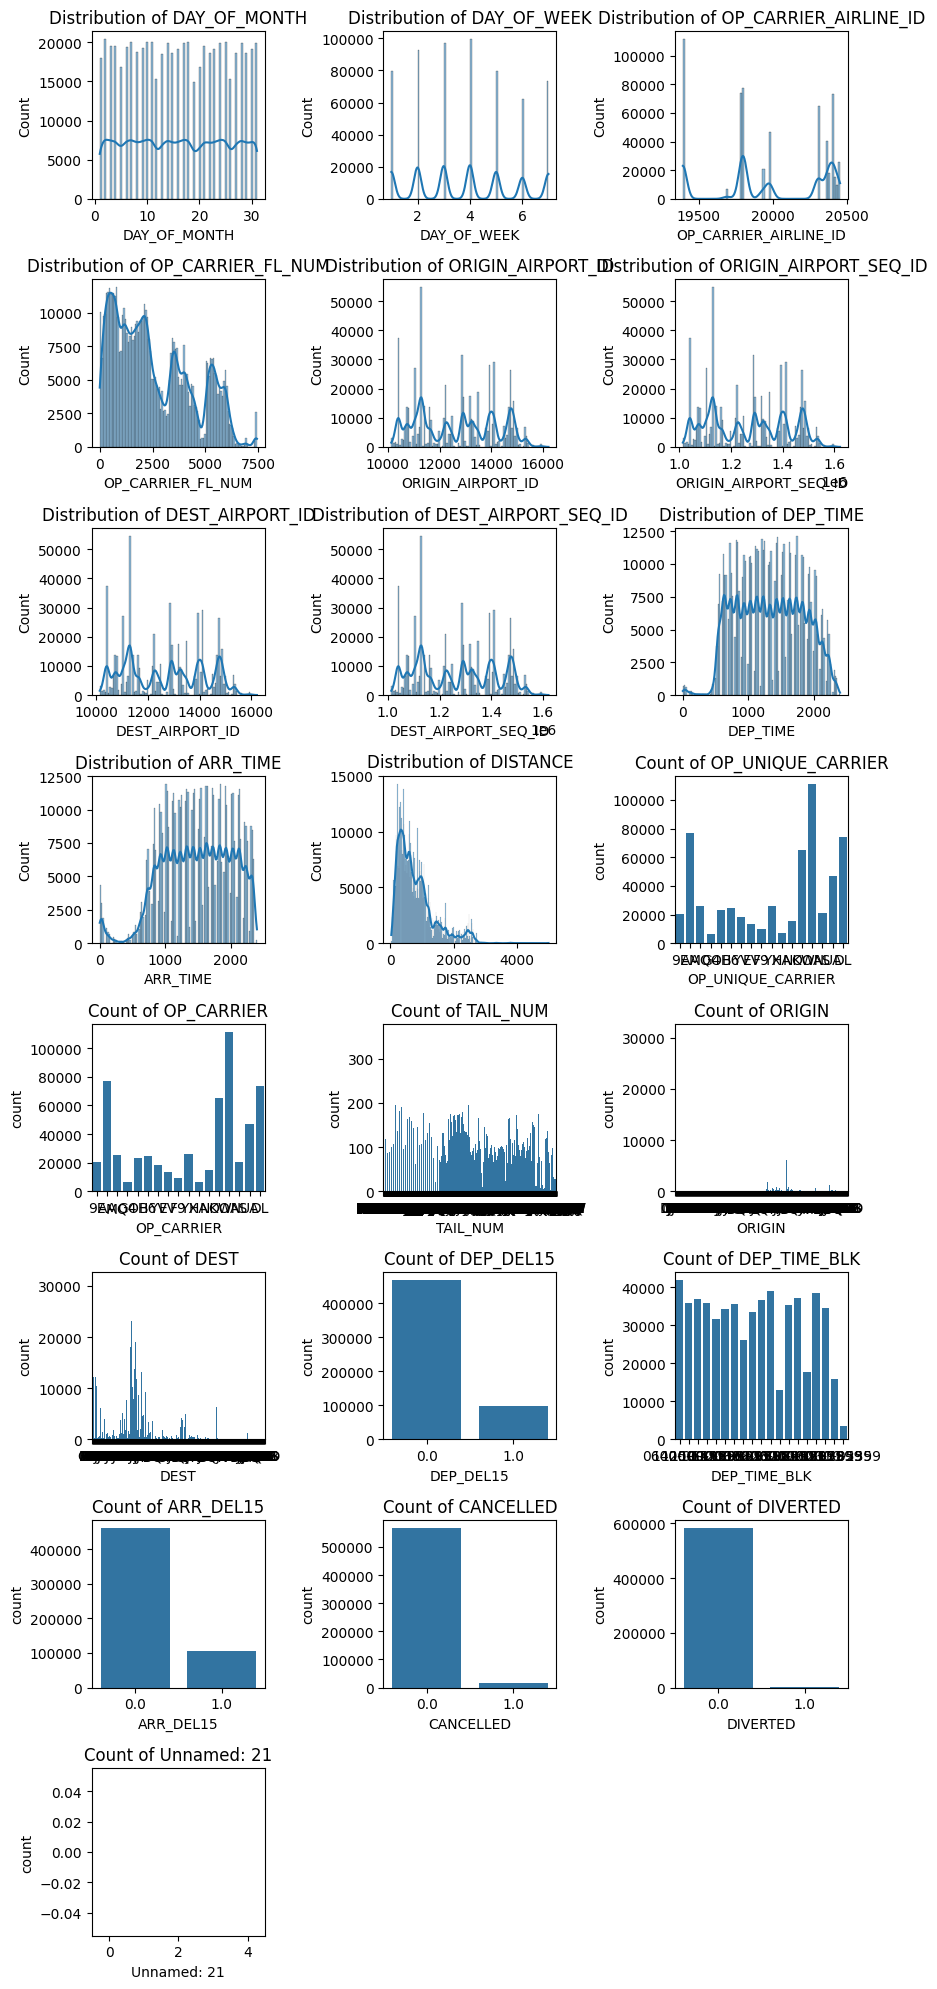

In [117]:
numerical_cols = flights_2019.select_dtypes(include=['number']).columns.tolist()
categorical_cols = flights_2019.select_dtypes(include=['object', 'category']).columns.tolist()
num_numeric = len(numerical_cols)
num_categorical = len(categorical_cols)
total_plots = num_numeric + num_categorical

# Create subplots grid
cols = 3  # Number of columns in the grid
rows = math.ceil(total_plots / cols)  # Calculate rows to fit all plots, round up
fig, axes = plt.subplots(rows, cols, figsize=(9, 2.5 * rows))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot histograms for numeric columns
for i, col in enumerate(numerical_cols):
    sns.histplot(data=flights_2019, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

# Plot count plots for categorical columns
for j, col in enumerate(categorical_cols, start=len(numerical_cols)):
    sns.countplot(data=flights_2019, x=col, ax=axes[j])
    axes[j].set_title(f"Count of {col}")

# Hide unused subplots
for k in range(total_plots, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [118]:
# Normal distribution
for col in flights_2019[numerical_cols]:
    stat, p_value = stats.shapiro(flights_2019[col])
    # Check if the data is normal
    if p_value > 0.05:
        print(f'{col} is normally distributed (fail to reject H0).')
    else:
        print(f'{col} is not normally distributed (reject H0).')

DAY_OF_MONTH is not normally distributed (reject H0).
DAY_OF_WEEK is not normally distributed (reject H0).
OP_CARRIER_AIRLINE_ID is not normally distributed (reject H0).
OP_CARRIER_FL_NUM is not normally distributed (reject H0).
ORIGIN_AIRPORT_ID is not normally distributed (reject H0).
ORIGIN_AIRPORT_SEQ_ID is not normally distributed (reject H0).
DEST_AIRPORT_ID is not normally distributed (reject H0).
DEST_AIRPORT_SEQ_ID is not normally distributed (reject H0).
DEP_TIME is not normally distributed (reject H0).
ARR_TIME is not normally distributed (reject H0).
DISTANCE is not normally distributed (reject H0).


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 583985.
  res = hypotest_fun_out(*samples, **kwds)


In [119]:
# Outliers
for col in flights_2019[numerical_cols]:
    Q1 = flights_2019[col].quantile(0.25)
    Q3 = flights_2019[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR


    outliers = flights_2019[(flights_2019[col] < lower_bound) | (flights_2019[col] > upper_bound)]
    print(f'{col} column: {len(outliers)} outliers')

DAY_OF_MONTH column: 0 outliers
DAY_OF_WEEK column: 0 outliers
OP_CARRIER_AIRLINE_ID column: 0 outliers
OP_CARRIER_FL_NUM column: 0 outliers
ORIGIN_AIRPORT_ID column: 0 outliers
ORIGIN_AIRPORT_SEQ_ID column: 0 outliers
DEST_AIRPORT_ID column: 0 outliers
DEST_AIRPORT_SEQ_ID column: 0 outliers
DEP_TIME column: 0 outliers
ARR_TIME column: 0 outliers
DISTANCE column: 32931 outliers


Correlations

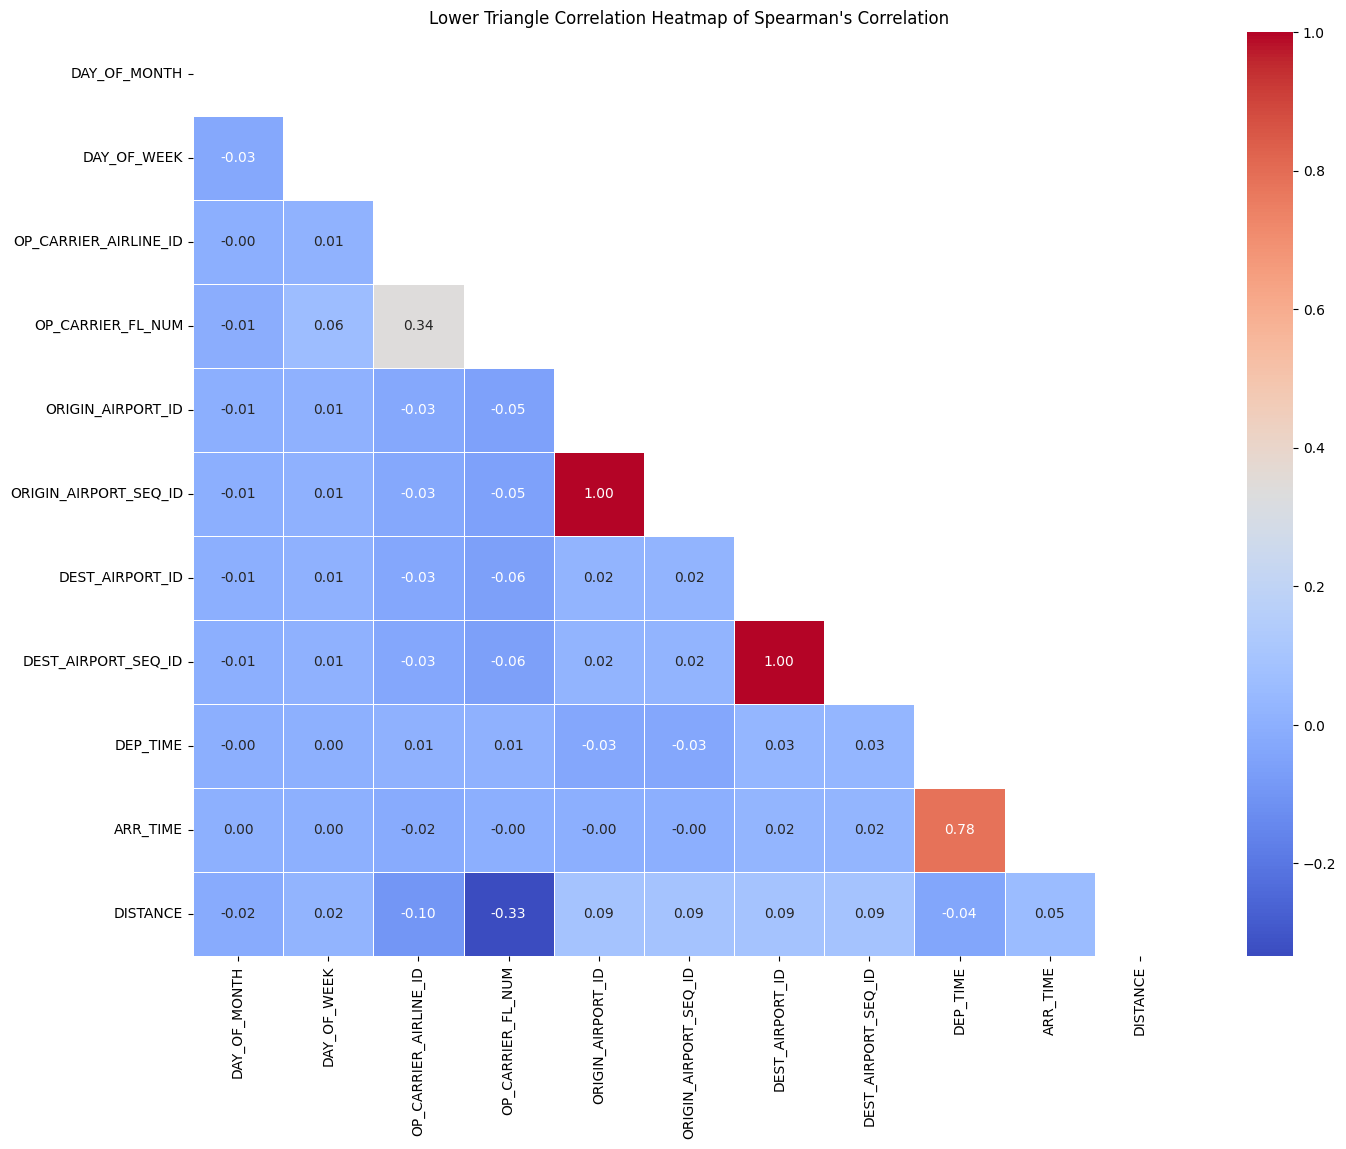

In [120]:
numerical_cols_data = flights_2019[numerical_cols]
corr_spearman = numerical_cols_data.corr(method='spearman')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_spearman, dtype=bool))  # Upper triangle mask

# Set up the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_spearman, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Lower Triangle Correlation Heatmap of Spearman's Correlation")
plt.show()

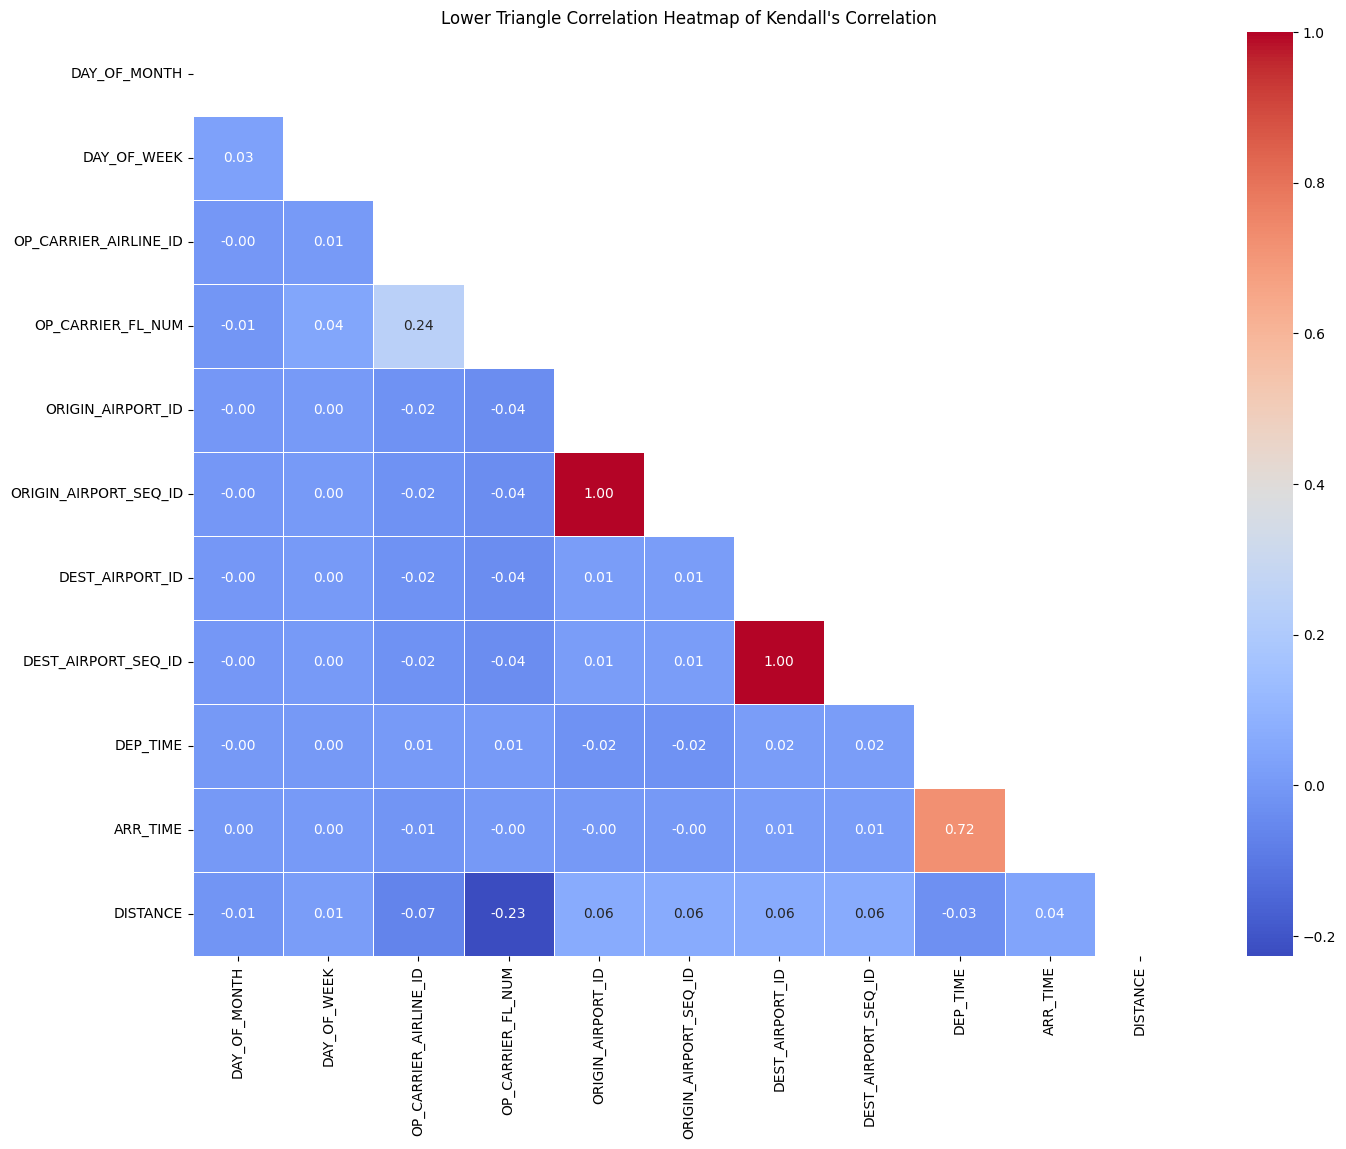

In [121]:
numerical_cols_data = flights_2019[numerical_cols]
corr_kendall = numerical_cols_data.corr(method='kendall')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_spearman, dtype=bool))  # Upper triangle mask

# Set up the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_kendall, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Lower Triangle Correlation Heatmap of Kendall's Correlation")
plt.show()

In [122]:
# Is there a correlation between the flights that departed late and them arriving late?
correlation = flights_2019['DEP_DEL15'].corr(flights_2019['ARR_DEL15'])
print(f"Correlation: {correlation}")

Correlation: 0.7194299212037121


# Percentages of the flights
The percentage of delayed, cancelled, and diverted flights

Delayed Percentage: 34.957918439685955 %
Delayed Arrivals:  105222 %
Delayed Departures:  98927 %


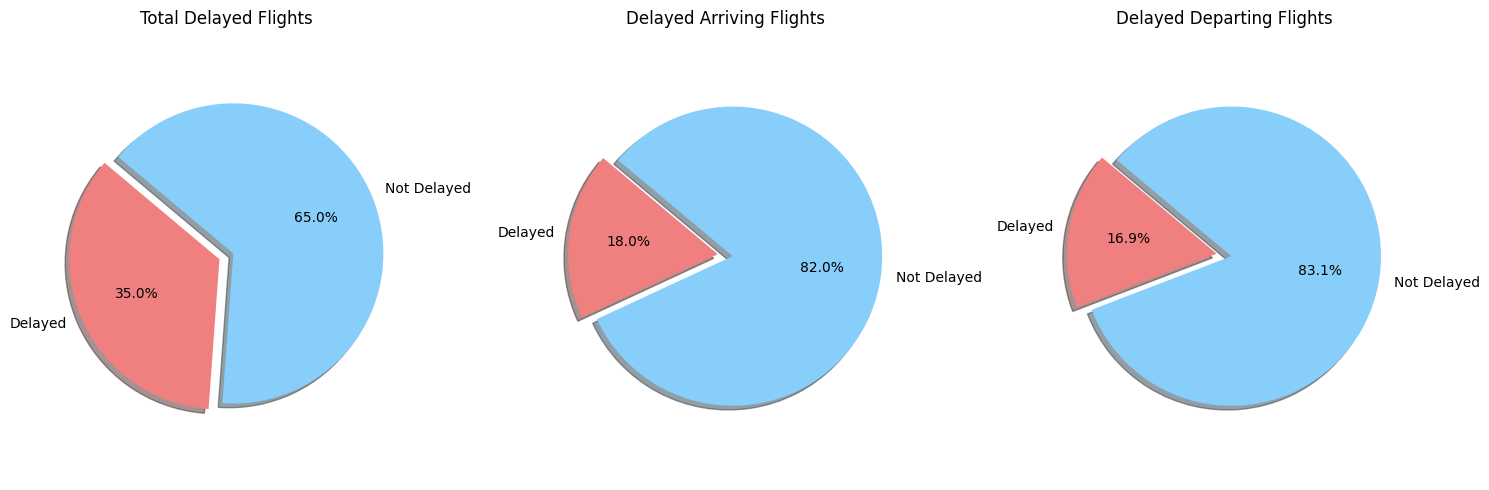

In [123]:
# Delayed flights
delayed_ARR = flights_2019[flights_2019['ARR_DEL15']==1]
delayed_DEP = flights_2019[flights_2019['DEP_DEL15']==1]
total_delayed = len(delayed_ARR)+len(delayed_DEP)
total_flights = len(flights_2019)
delayed_percentage = (total_delayed / total_flights) * 100
print("Delayed Percentage:", delayed_percentage,'%')
print('Delayed Arrivals: ', len(delayed_ARR), '%')
print('Delayed Departures: ', len(delayed_DEP), '%')

labels_delayed = ['Delayed', 'Not Delayed']
sizes_delayed = [total_delayed, total_flights - total_delayed]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

sizes_delayed_ARR = [len(delayed_ARR), len(flights_2019) - len(delayed_ARR)]
sizes_delayed_DEP = [len(delayed_DEP), len(flights_2019) - len(delayed_DEP)]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].pie(sizes_delayed, explode=explode, labels=labels_delayed, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
axs[0].axis('equal')
axs[0].set_title('Total Delayed Flights')

axs[1].pie(sizes_delayed_ARR, explode=explode, labels=labels_delayed, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
axs[1].axis('equal')
axs[1].set_title('Delayed Arriving Flights')

axs[2].pie(sizes_delayed_DEP, explode=explode, labels=labels_delayed, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
axs[2].axis('equal')
axs[2].set_title('Delayed Departing Flights')

plt.tight_layout()
plt.show()

In [124]:
# Percentage of flights delayed at departure and arrival
delayedx2 = flights_2019[(flights_2019['DEP_DEL15'] == 1) & (flights_2019['ARR_DEL15'] == 1)]
delayedx2_percentage = (len(delayedx2) / len(flights_2019)) * 100
print("Delayed Percentage:", delayedx2_percentage, '%')

Delayed Percentage: 13.405823779720368 %


35% of the flights are delayes, this is somewhat imbalanced but not severely (mildly imbalanced). But from all the flights, 13% are both delayed at departure and arrival, leaving the total percentage of delayed flights in 22%

Cancelled and diverted flights

Number of cancelled flights: 16726 out of 583985  =  2.864114660479293 %
Number of cancelled and delayed flights: 184 = 0.03150765858712125 %


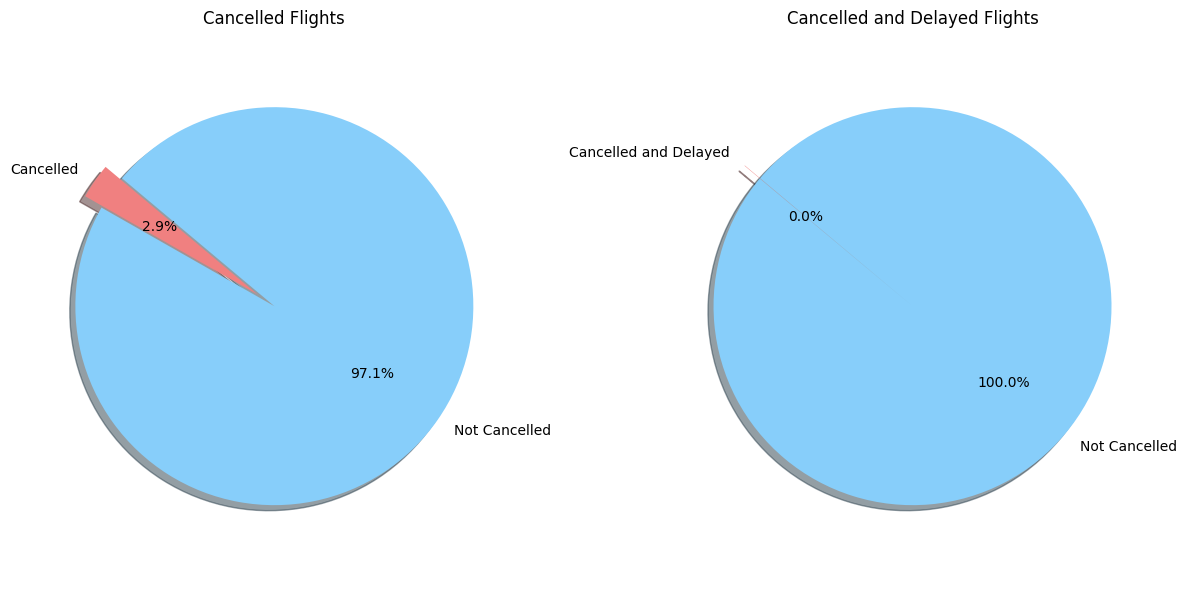

In [125]:
# Cancelled and delayed flights
cancelled_count = (flights_2019['CANCELLED'] == 1).sum()

print("Number of cancelled flights:", cancelled_count, "out of", len(flights_2019), ' = ', (cancelled_count/len(flights_2019))*100, '%')

cancelled = flights_2019[flights_2019['CANCELLED'] == 1]
cancelled_delayed_ARR = cancelled[cancelled['ARR_DEL15'] == 1]
cancelled_delayed_DEP = cancelled[cancelled['DEP_DEL15'] == 1]
print ('Number of cancelled and delayed flights:', len(cancelled_delayed_DEP)+len(cancelled_delayed_ARR), '=', (len(cancelled_delayed_DEP)+len(cancelled_delayed_ARR))/len(flights_2019)*100, '%')

# Pie chart
labels_cancelled = ['Cancelled', 'Not Cancelled']
sizes_cancelled = [cancelled_count, len(flights_2019) - cancelled_count]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

labels_delayed = ['Cancelled and Delayed', 'Not Cancelled']
sizes_delayed = [len(cancelled_delayed_DEP)+len(cancelled_delayed_ARR), len(flights_2019) - (len(cancelled_delayed_DEP)+len(cancelled_delayed_ARR))]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].pie(sizes_cancelled, explode=explode, labels=labels_cancelled, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
axs[0].axis('equal')
axs[0].set_title('Cancelled Flights')

axs[1].pie(sizes_delayed, explode=explode, labels=labels_delayed, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
axs[1].axis('equal')
axs[1].set_title('Cancelled and Delayed Flights')

plt.tight_layout()
plt.show()

In [126]:
cancelled.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
397,1,2,AA,19805,AA,N965NN,178,14027,1402702,PBI,13930,1393007,ORD,NaN,NaN,0600-0659,NaN,NaN,1.0,0.0,1143.0,NaN
403,1,2,AA,19805,AA,N9015D,189,11503,1150305,EGE,11298,1129806,DFW,NaN,NaN,0700-0759,NaN,NaN,1.0,0.0,721.0,NaN
971,1,2,OH,20397,OH,N572NN,5103,11057,1105703,CLT,14193,1419306,PNS,1953.0,0.0,1900-1959,NaN,NaN,1.0,0.0,488.0,NaN
1973,1,2,EV,20366,EV,N17984,4187,12448,1244807,JAN,12266,1226603,IAH,NaN,NaN,0900-0959,NaN,NaN,1.0,0.0,351.0,NaN
1975,1,2,EV,20366,EV,N17984,4189,12266,1226603,IAH,12448,1244807,JAN,NaN,NaN,0700-0759,NaN,NaN,1.0,0.0,351.0,NaN


Number of diverted flights: 1296 out of 583985  =  0.22192350830928875 %


Text(0.5, 1.0, 'Diverted Flights')

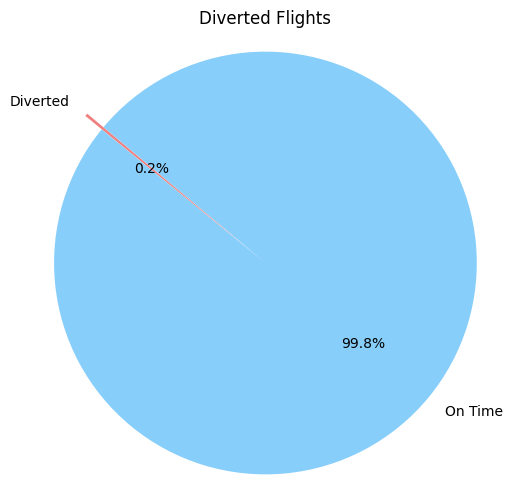

In [127]:
# Diverted flights
diverted_count = (flights_2019['DIVERTED'] == 1).sum()

print("Number of diverted flights:", diverted_count, "out of", len(flights_2019), ' = ', (diverted_count/len(flights_2019))*100, '%')

labels_diverted = ['Diverted', 'On Time']
sizes = [diverted_count, len(flights_2019) - diverted_count]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels_diverted, colors=colors, explode=explode,
       autopct='%1.1f%%', startangle=140)
ax.axis('equal')
plt.title('Diverted Flights')

In [128]:
divertes_flights = flights_2019[flights_2019['DIVERTED'] == 1]
divertes_flights.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
1250,1,2,B6,20409,B6,N613JB,358,10800,1080003,BUR,12478,1247805,JFK,2203.0,0.0,2100-2159,709.0,NaN,0.0,1.0,2465.0,NaN
1633,1,2,B6,20409,B6,N184JB,1210,12451,1245102,JAX,10721,1072102,BOS,1201.0,0.0,1200-1259,1810.0,NaN,0.0,1.0,1010.0,NaN
1866,1,2,B6,20409,B6,N627JB,2338,10800,1080003,BUR,10721,1072102,BOS,2040.0,1.0,2000-2059,610.0,NaN,0.0,1.0,2601.0,NaN
1868,1,2,B6,20409,B6,N709JB,2358,10800,1080003,BUR,12478,1247805,JFK,1500.0,1.0,1400-1459,43.0,NaN,0.0,1.0,2465.0,NaN
1879,1,2,B6,20409,B6,N999JB,2451,10721,1072102,BOS,13204,1320402,MCO,934.0,0.0,0900-0959,1456.0,NaN,0.0,1.0,1121.0,NaN


In [129]:
# Cancelled and diverted flights
cancelled_diverted = divertes_flights[divertes_flights['CANCELLED'] == 1]
print('Number of cancelled and diverted flights:', len(cancelled_diverted))

Number of cancelled and diverted flights: 0


Info on delayed flights

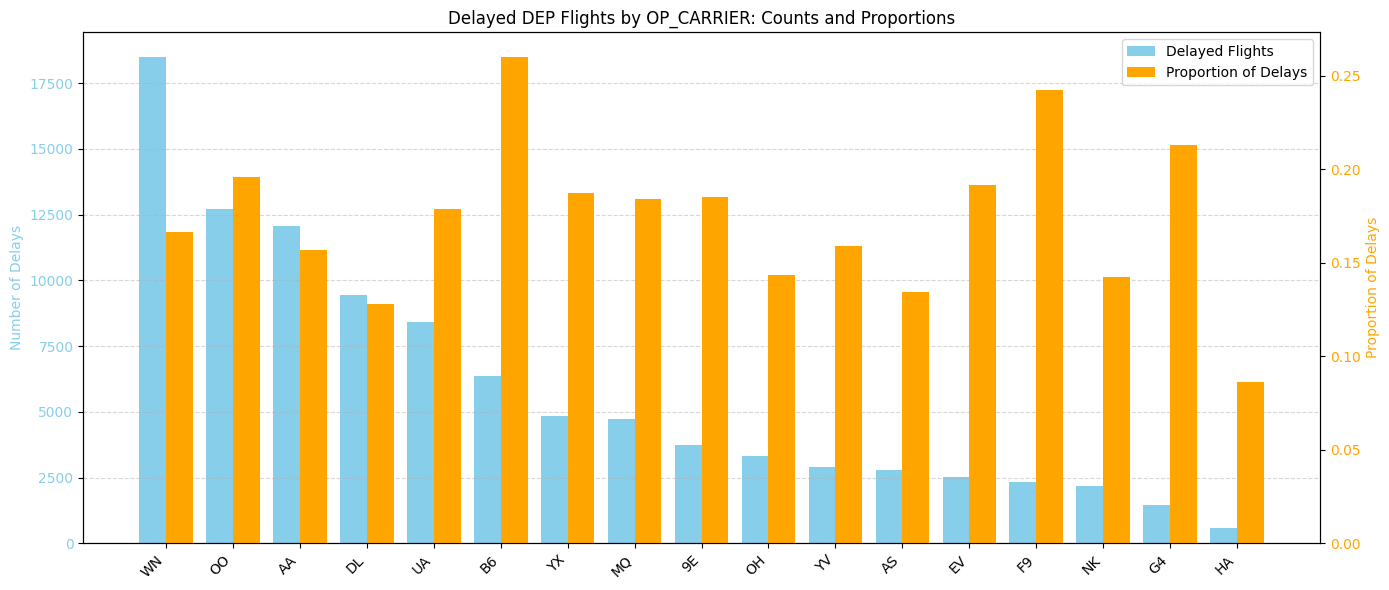

,delays,total,proportion
OP_CARRIER,,,
WN,18507,111312,0.166262
OO,12714,64926,0.195823
AA,12077,77017,0.156810
DL,9462,73836,0.128149
UA,8401,46915,0.179069
B6,6362,24443,0.260279
YX,4827,25755,0.187420
MQ,4737,25699,0.184326
9E,3746,20198,0.185464


In [130]:
delayed_graph(flights_2019, 'dep', 'OP_CARRIER', 'skyblue')


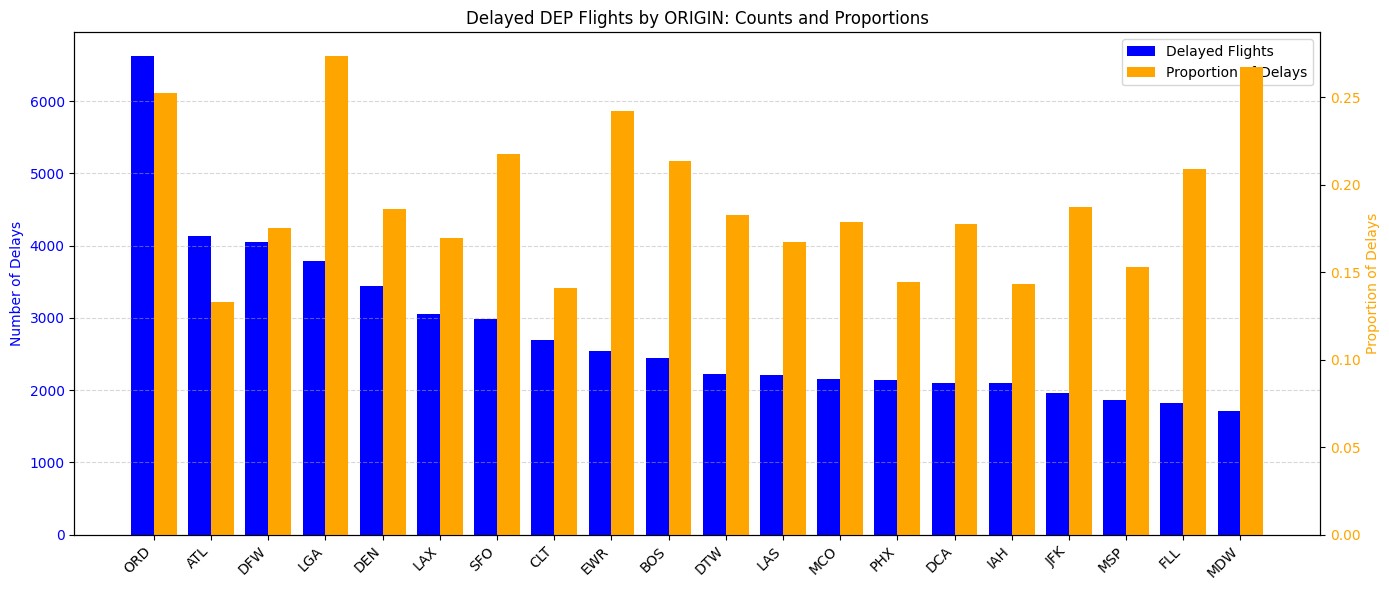

,delays,total,proportion
ORIGIN,,,
ORD,6620.0,26216,0.252518
ATL,4133.0,31155,0.132659
DFW,4044.0,23063,0.175346
LGA,3791.0,13872,0.273284
DEN,3438.0,18507,0.185768
LAX,3047.0,17988,0.169391
SFO,2977.0,13689,0.217474
CLT,2689.0,19100,0.140785
EWR,2544.0,10522,0.241779


In [131]:
delayed_graph(flights_2019, 'dep', 'ORIGIN', 'blue')

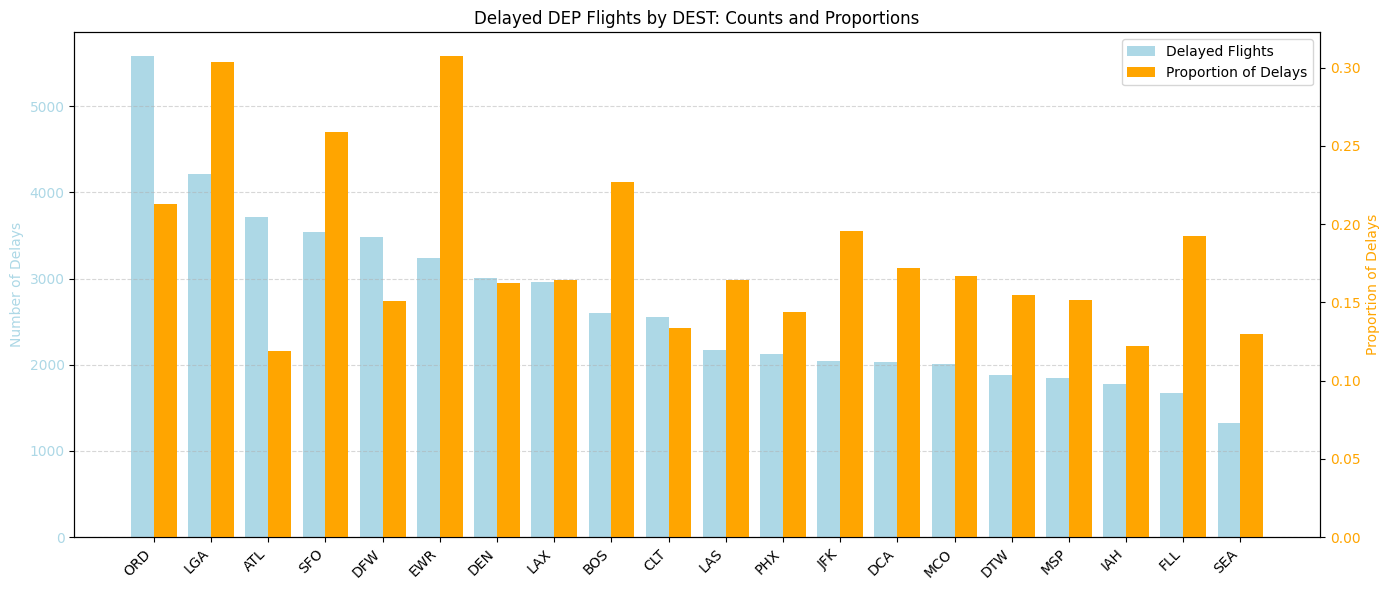

,delays,total,proportion
DEST,,,
ORD,5579.0,26212,0.212841
LGA,4218.0,13882,0.303847
ATL,3710.0,31151,0.119097
SFO,3543.0,13702,0.258575
DFW,3477.0,23078,0.150663
EWR,3236.0,10536,0.307137
DEN,3006.0,18498,0.162504
LAX,2957.0,17977,0.164488
BOS,2596.0,11429,0.227141


In [132]:
delayed_graph(flights_2019, 'dep', 'DEST', 'lightblue')

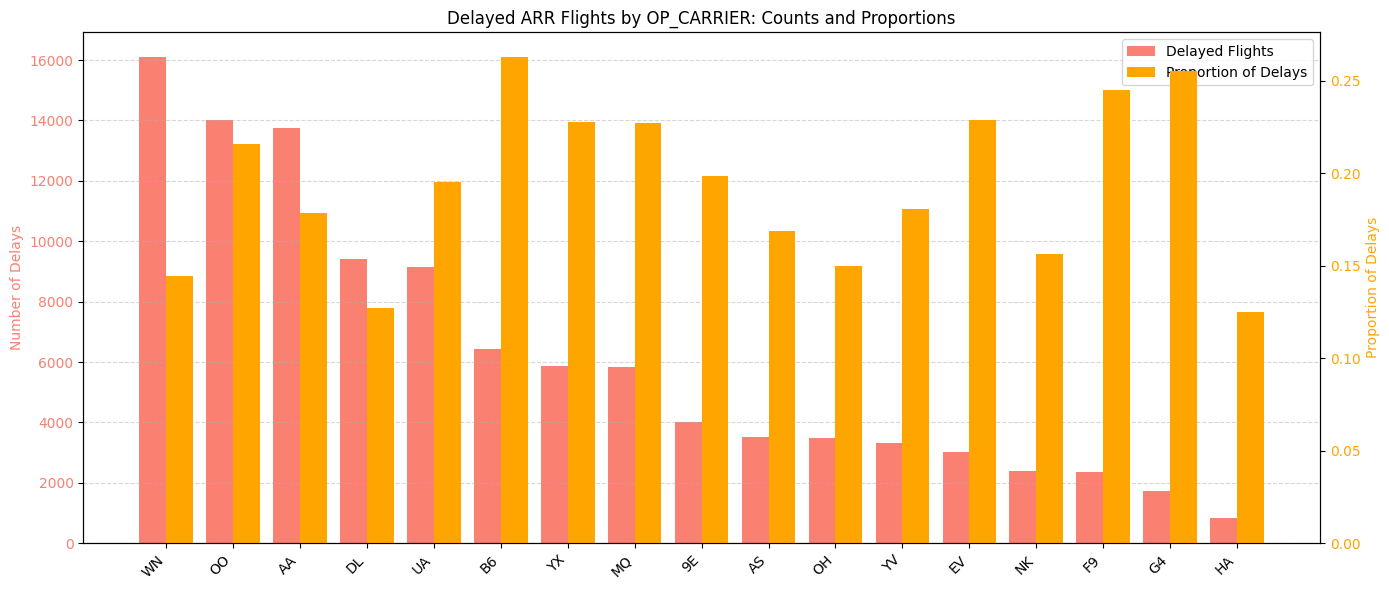

,delays,total,proportion
OP_CARRIER,,,
WN,16111,111312,0.144737
OO,14024,64926,0.216000
AA,13741,77017,0.178415
DL,9403,73836,0.127350
UA,9156,46915,0.195161
B6,6429,24443,0.263020
YX,5864,25755,0.227684
MQ,5844,25699,0.227402
9E,4013,20198,0.198683


In [133]:
delayed_graph(flights_2019, 'arr', 'OP_CARRIER', 'salmon')


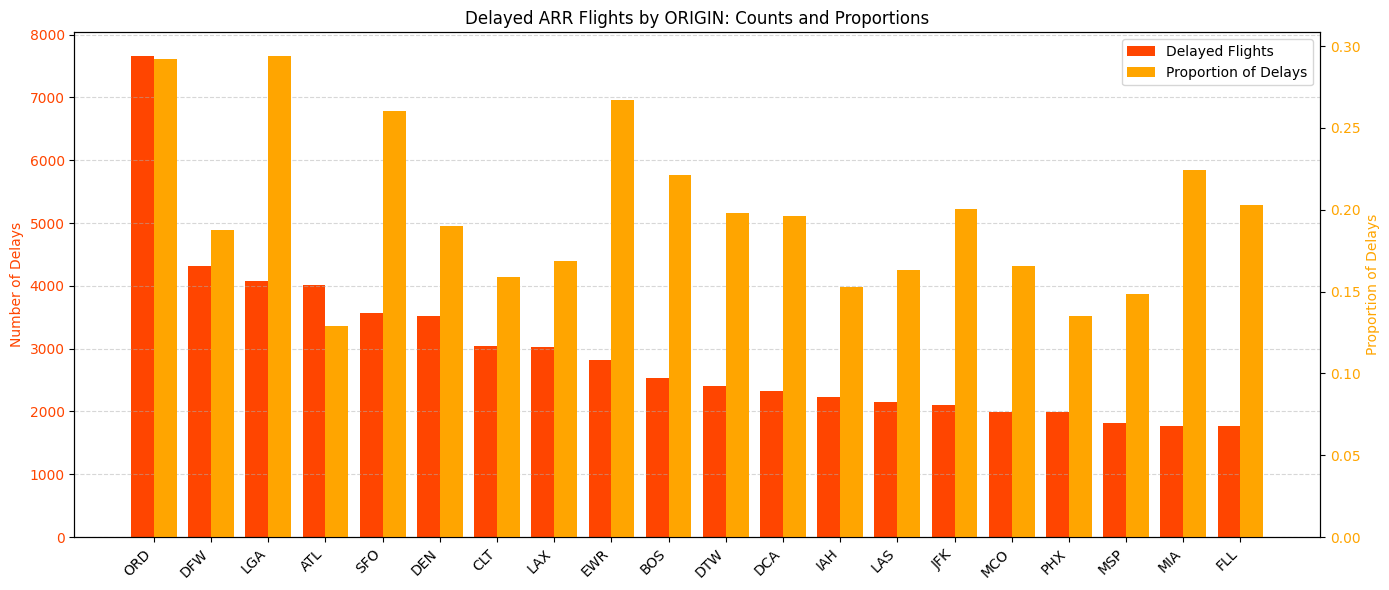

,delays,total,proportion
ORIGIN,,,
ORD,7655.0,26216,0.291997
DFW,4322.0,23063,0.187400
LGA,4075.0,13872,0.293757
ATL,4013.0,31155,0.128808
SFO,3562.0,13689,0.260209
DEN,3513.0,18507,0.189820
CLT,3035.0,19100,0.158901
LAX,3033.0,17988,0.168612
EWR,2813.0,10522,0.267345


In [134]:
delayed_graph(flights_2019, 'arr', 'ORIGIN', 'orangered')


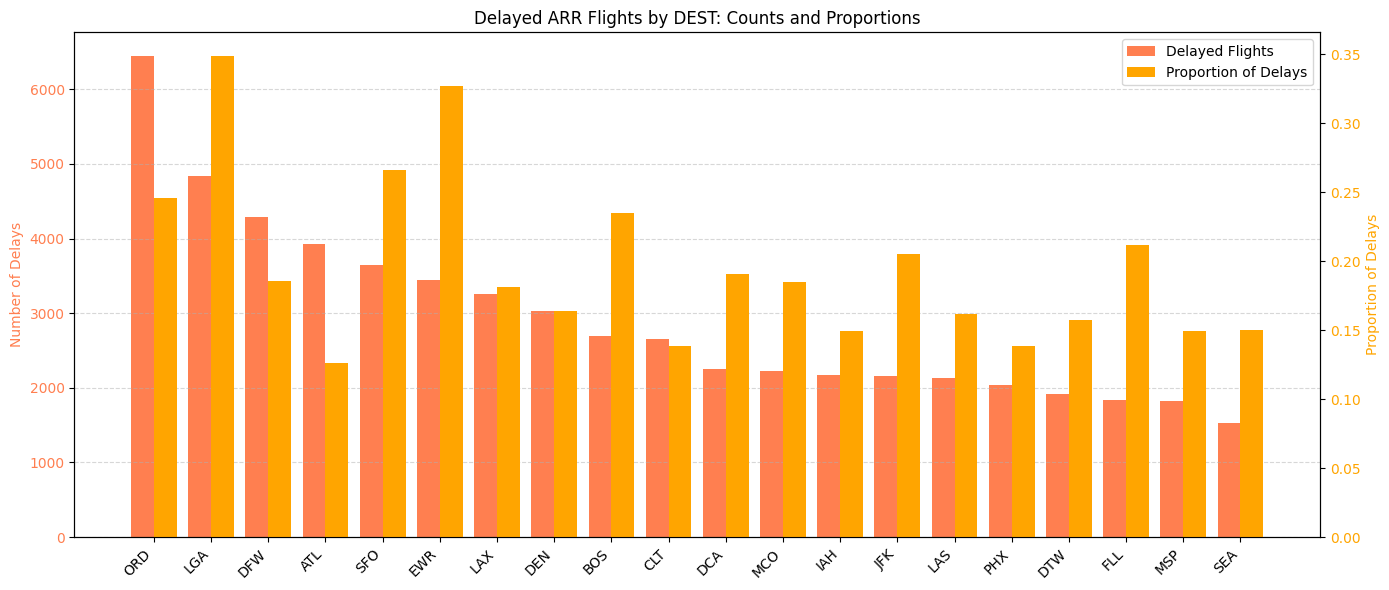

,delays,total,proportion
DEST,,,
ORD,6441.0,26212,0.245727
LGA,4836.0,13882,0.348365
DFW,4282.0,23078,0.185545
ATL,3931.0,31151,0.126192
SFO,3642.0,13702,0.265801
EWR,3445.0,10536,0.326974
LAX,3263.0,17977,0.181510
DEN,3025.0,18498,0.163531
BOS,2688.0,11429,0.235191


In [135]:
delayed_graph(flights_2019, 'arr', 'DEST', 'coral')

From the graphs above we can see that the flights from/to ORD are significantly more delayed than any other destination. Furthermore, the carrier with the most delayed flights id WN

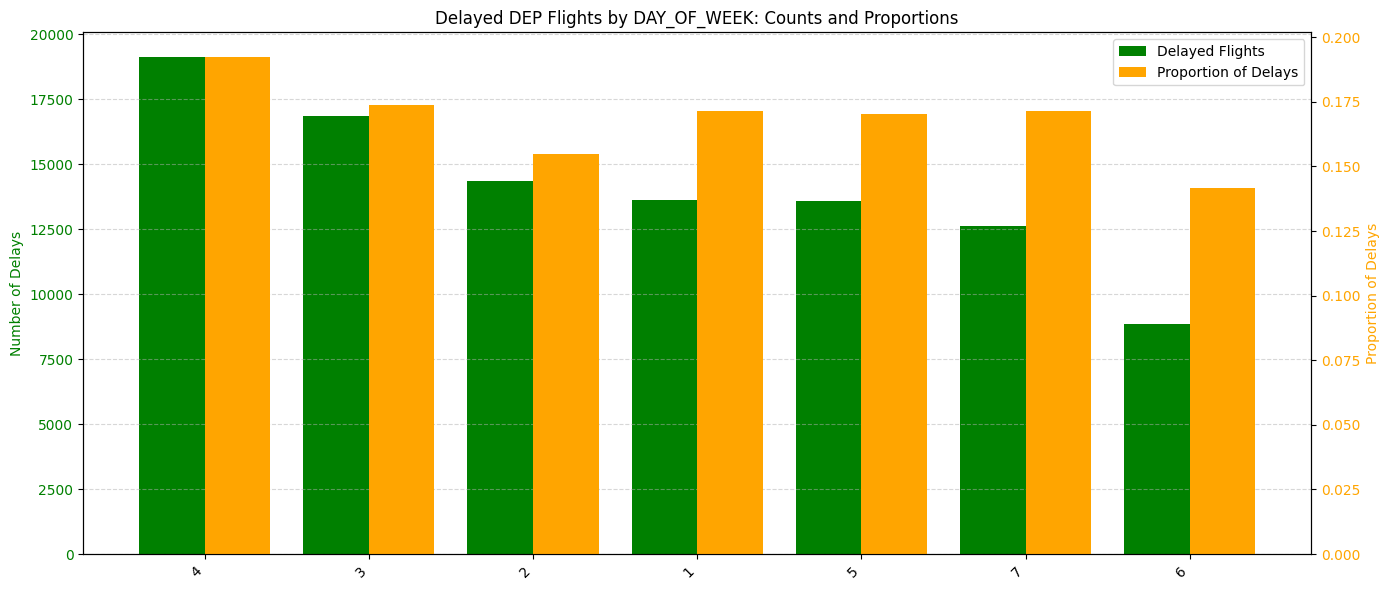

,delays,total,proportion
DAY_OF_WEEK,,,
4,19111,99387,0.192289
3,16860,96920,0.173958
2,14358,92796,0.154726
1,13600,79401,0.171282
5,13565,79698,0.170205
7,12600,73459,0.171524
6,8833,62324,0.141727


In [136]:
delayed_graph(flights_2019, 'dep', 'DAY_OF_WEEK', 'green')

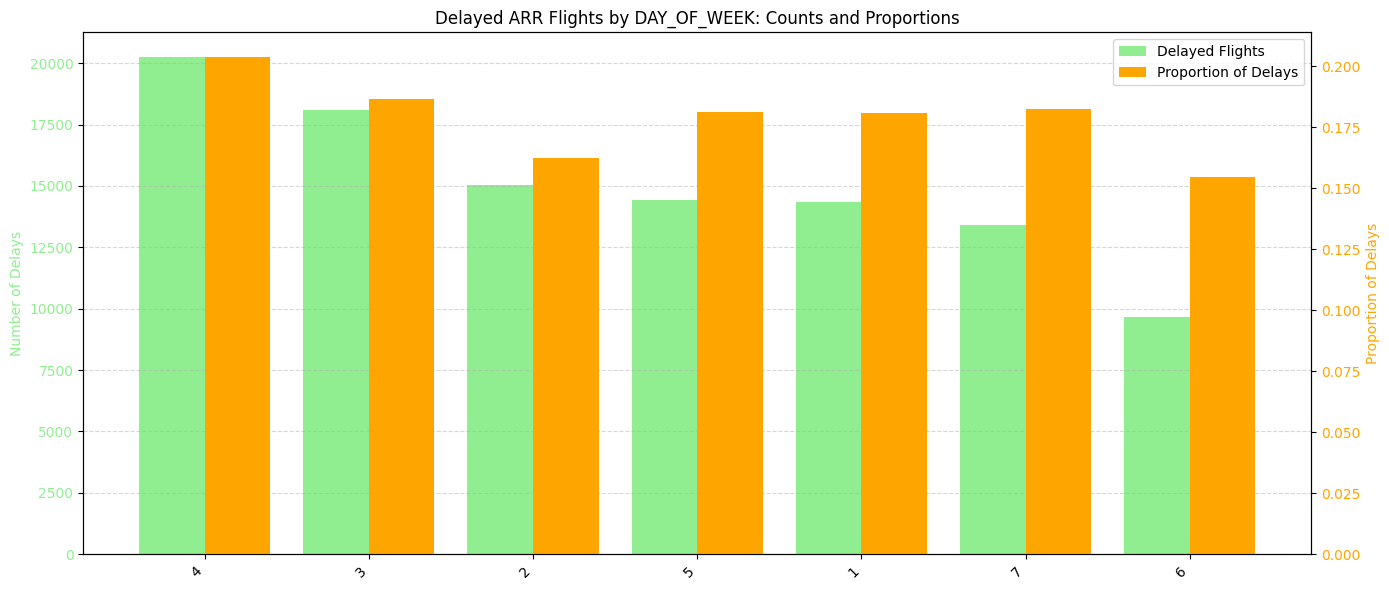

,delays,total,proportion
DAY_OF_WEEK,,,
4,20249,99387,0.203739
3,18082,96920,0.186566
2,15059,92796,0.162281
5,14430,79698,0.181058
1,14350,79401,0.180728
7,13410,73459,0.182551
6,9642,62324,0.154708


In [137]:
delayed_graph(flights_2019, 'arr', 'DAY_OF_WEEK', 'lightgreen')

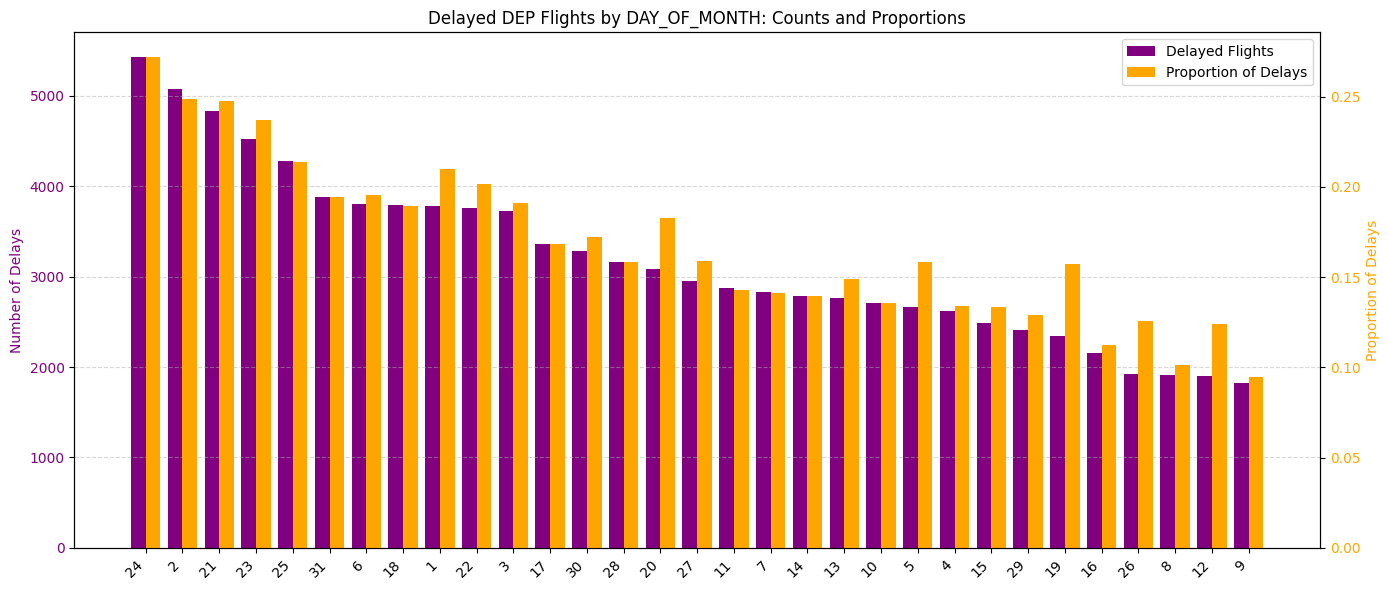

,delays,total,proportion
DAY_OF_MONTH,,,
24,5432,19963,0.272103
2,5075,20384,0.248970
21,4832,19511,0.247655
23,4525,19099,0.236923
25,4281,20041,0.213612
31,3881,19962,0.194419
6,3800,19448,0.195393
18,3792,20009,0.189515
1,3783,18009,0.210062


In [138]:
delayed_graph(flights_2019, 'dep', 'DAY_OF_MONTH', 'purple')

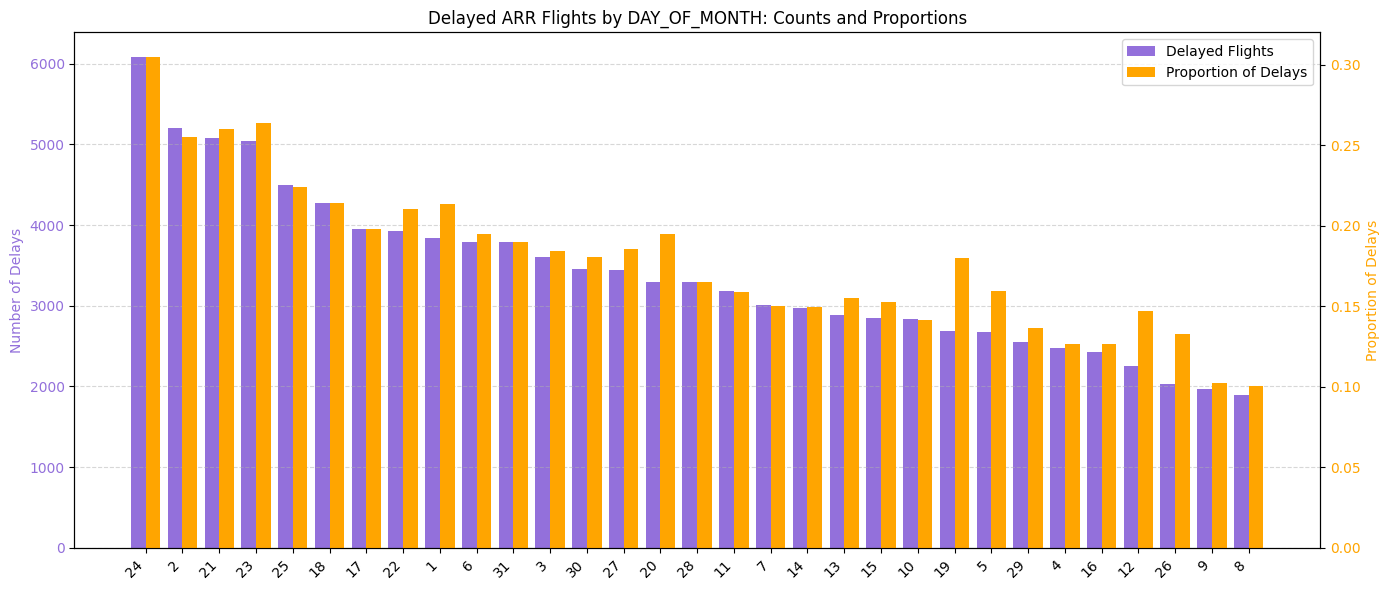

,delays,total,proportion
DAY_OF_MONTH,,,
24,6084,19963,0.304764
2,5203,20384,0.255249
21,5073,19511,0.260007
23,5037,19099,0.263731
25,4494,20041,0.224240
18,4278,20009,0.213804
17,3947,19960,0.197745
22,3929,18657,0.210591
1,3844,18009,0.213449


In [139]:
delayed_graph(flights_2019, 'arr', 'DAY_OF_MONTH', 'mediumpurple')

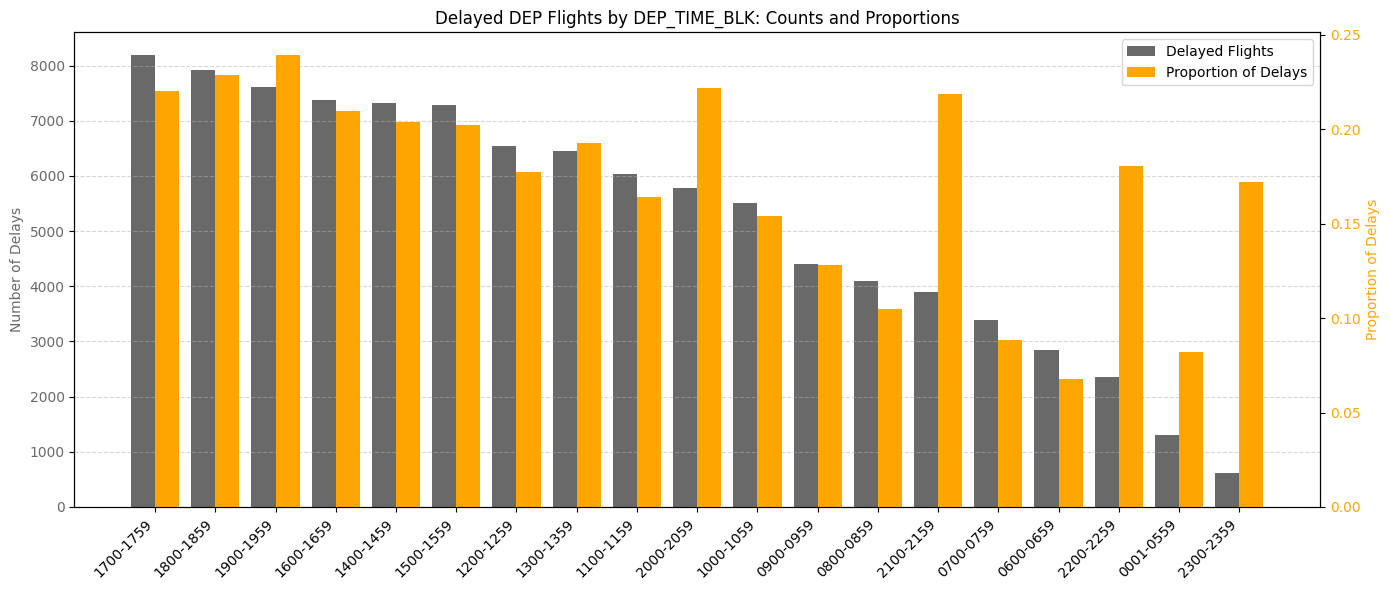

,delays,total,proportion
DEP_TIME_BLK,,,
1700-1759,8194,37254,0.219950
1800-1859,7929,34670,0.228699
1900-1959,7615,31823,0.239292
1600-1659,7380,35250,0.209362
1400-1459,7324,35925,0.203869
1500-1559,7286,35988,0.202456
1200-1259,6542,36918,0.177204
1300-1359,6444,33413,0.192859
1100-1159,6030,36774,0.163975


In [140]:
delayed_graph(flights_2019, 'dep', 'DEP_TIME_BLK', 'dimgray')

From the graphs above we can conclude:
*   The airline with most delays, both departuring and arriving, is Sowthwest
Airlines (WN). But prpotionally JetBlue (B6) has the most delays with more than 0.25 of the flights being late
*   The airport with the most delays, again departuring and arriving, is Chicago O'Hare International Airport (ORD). Proportionally, ORD and LGA (LaGuardia Airport) with more than 0.3 of the flights being late in arrival and departure.
*   The day of the week with most delays was Thursday (4)
*   The day of the month with most delays was the 24th of January. On January 24th 2019 USA was under a general shutdown that affected flight departures due to staff shortage.
*   The time block were most departuring delays happened was 15:00 - 19:59

# Feature engineering

Since DEP_DEL15 and ARR_DEL15 are highly correlated (0.719) I will combine both into one column DEL_15 to avoid multicolinearity

In [10]:
flights_2019['DEL_15'] = (flights_2019['ARR_DEL15'].astype(bool) | flights_2019['DEP_DEL15'].astype(bool)).astype(int)
flights_2020['DEL_15'] = (flights_2020['ARR_DEL15'].astype(bool) | flights_2020['DEP_DEL15'].astype(bool)).astype(int)

Delayed Percentage: 24.5316232437477 %


Text(0.5, 1.0, 'Delayed Flights - pooled')

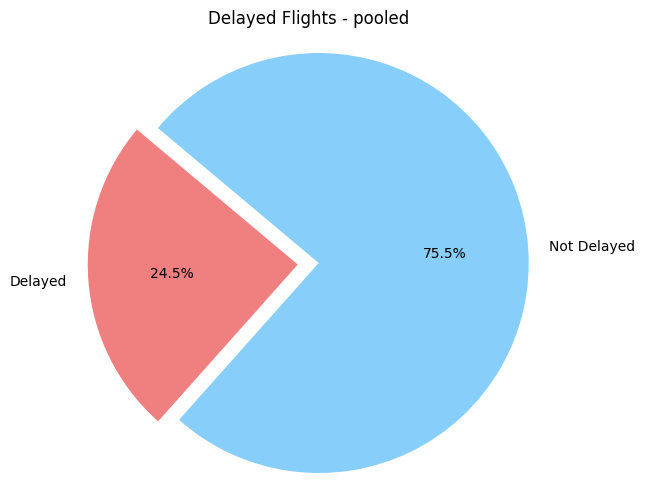

In [11]:
# Delayed flights after pooling

total_delayed = len(flights_2019[flights_2019['DEL_15']==1])
total_flights = len(flights_2019)
delayed_percentage = (total_delayed / total_flights) * 100
print("Delayed Percentage:", delayed_percentage,'%')


labels_delayed = ['Delayed', 'Not Delayed']
sizes_delayed = [total_delayed, total_flights - total_delayed]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes_delayed, labels=labels_delayed, colors=colors, explode=explode,
       autopct='%1.1f%%', startangle=140)
ax.axis('equal')
plt.title('Delayed Flights - pooled')

In [12]:
# Dropping unuseful column to decrease dimensionality and ARR_TIME that is highly correlated with DEP_TIME
flights_2019.drop(['OP_CARRIER_AIRLINE_ID','TAIL_NUM','OP_CARRIER_FL_NUM','ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID','Unnamed: 21','OP_CARRIER','ARR_DEL15','DEP_DEL15', 'ARR_TIME'], axis=1, inplace=True)
flights_2020.drop(['OP_CARRIER_AIRLINE_ID','TAIL_NUM','OP_CARRIER_FL_NUM','ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID','Unnamed: 21','OP_CARRIER','ARR_DEL15','DEP_DEL15', 'ARR_TIME'], axis=1, inplace=True)

In [13]:
flights_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583985 entries, 0 to 583984
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DAY_OF_MONTH       583985 non-null  int64  
 1   DAY_OF_WEEK        583985 non-null  int64  
 2   OP_UNIQUE_CARRIER  583985 non-null  object 
 3   ORIGIN             583985 non-null  object 
 4   DEST               583985 non-null  object 
 5   DEP_TIME           567633 non-null  float64
 6   DEP_TIME_BLK       583985 non-null  object 
 7   CANCELLED          583985 non-null  float64
 8   DIVERTED           583985 non-null  float64
 9   DISTANCE           583985 non-null  float64
 10  DEL_15             583985 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 49.0+ MB


In [145]:
missing_dep = flights_2019[flights_2019['DEP_TIME'].isna()]
missing_dep

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_TIME_BLK,CANCELLED,DIVERTED,DISTANCE,DEL_15
397,1,2,AA,PBI,ORD,NaN,0600-0659,1.0,0.0,1143.0,0
403,1,2,AA,EGE,DFW,NaN,0700-0759,1.0,0.0,721.0,0
1973,1,2,EV,JAN,IAH,NaN,0900-0959,1.0,0.0,351.0,0
1975,1,2,EV,IAH,JAN,NaN,0700-0759,1.0,0.0,351.0,0
1976,1,2,EV,IAH,ECP,NaN,1900-1959,1.0,0.0,572.0,0
...,...,...,...,...,...,...,...,...,...,...,...
583958,31,4,UA,PIT,ORD,NaN,1700-1759,1.0,0.0,413.0,0
583959,31,4,UA,BUF,ORD,NaN,0800-0859,1.0,0.0,473.0,0
583964,31,4,UA,CLE,ORD,NaN,1600-1659,1.0,0.0,315.0,0
583966,31,4,UA,BZN,ORD,NaN,0900-0959,1.0,0.0,1186.0,0


In [146]:
# Are all flights with missing departure time cancelled flights?
flights_2019[flights_2019['DEP_TIME'].isna()]['CANCELLED'].value_counts()

,count
CANCELLED,
1.0,16352
0.0,0


Since all the flughts with missinf DEP_TIME are also CANCELLED and this is the only data missing I will delte the cancelled flights from both datasets

In [14]:
flights_2019 = flights_2019[flights_2019['CANCELLED'] != 1]
flights_2020 = flights_2020[flights_2020['CANCELLED'] != 1]

Now the CANCELLED columns does not provide any information since all the flights are not cancelled. We can now delete this column

In [15]:
flights_2019.drop(['CANCELLED'], axis=1, inplace=True)
flights_2020.drop(['CANCELLED'], axis=1, inplace=True)

In [16]:
flights_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 567259 entries, 0 to 583984
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DAY_OF_MONTH       567259 non-null  int64  
 1   DAY_OF_WEEK        567259 non-null  int64  
 2   OP_UNIQUE_CARRIER  567259 non-null  object 
 3   ORIGIN             567259 non-null  object 
 4   DEST               567259 non-null  object 
 5   DEP_TIME           567259 non-null  float64
 6   DEP_TIME_BLK       567259 non-null  object 
 7   DIVERTED           567259 non-null  float64
 8   DISTANCE           567259 non-null  float64
 9   DEL_15             567259 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 47.6+ MB


Our dataset doesn't have any missing or correlated values

In [17]:
# Encode categorical columns
encode_categories(flights_2019, ['OP_UNIQUE_CARRIER' , 'ORIGIN' , 'DEST' , 'DEP_TIME_BLK'])
encode_categories(flights_2020, ['OP_UNIQUE_CARRIER' , 'ORIGIN' , 'DEST' , 'DEP_TIME_BLK'])

# Model

In [18]:
# Split dataset, use 2019 to train and 2020 to test
X_train = flights_2019.drop(columns=['DEL_15'])
X_test = flights_2020.drop(columns=['DEL_15'])

y_train = flights_2019['DEL_15']
y_test = flights_2020['DEL_15']

In [19]:
# Multicolinearity
vif_data = pd.DataFrame()
vif_data['Feature'] = X_train.columns
vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

,Feature,VIF
5,DEP_TIME,64.418675
6,DEP_TIME_BLK,35.906783
1,DAY_OF_WEEK,4.461161
4,DEST,4.020616
3,ORIGIN,3.960172
0,DAY_OF_MONTH,3.748472
2,OP_UNIQUE_CARRIER,3.395010
8,DISTANCE,2.814338
7,DIVERTED,1.002554


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogisticRegression Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91    496992
           1       0.66      0.01      0.02    103426

    accuracy                           0.83    600418
   macro avg       0.74      0.50      0.46    600418
weighted avg       0.80      0.83      0.75    600418



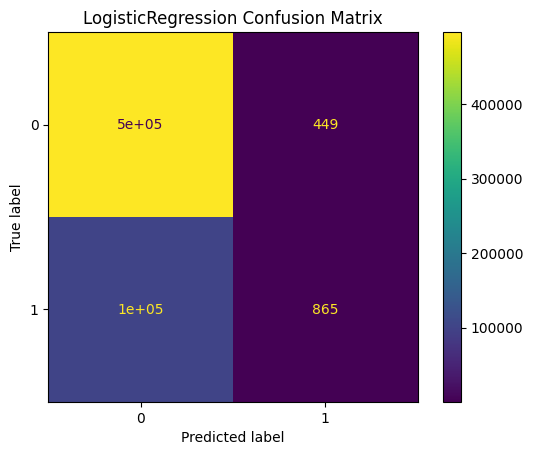


RandomForest Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94    496992
           1       0.80      0.54      0.65    103426

    accuracy                           0.90    600418
   macro avg       0.86      0.76      0.79    600418
weighted avg       0.89      0.90      0.89    600418



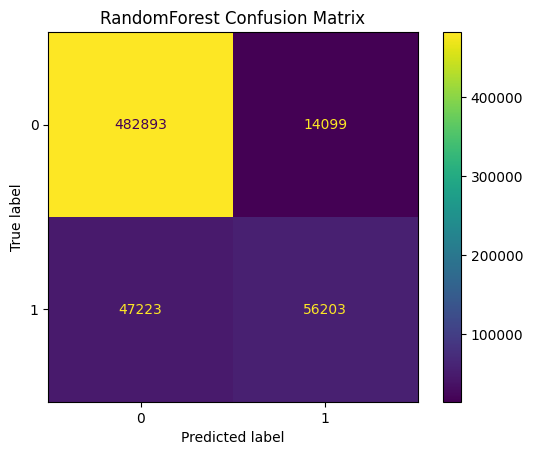


Decision Tree Report:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87    496992
           1       0.43      0.64      0.51    103426

    accuracy                           0.79    600418
   macro avg       0.67      0.73      0.69    600418
weighted avg       0.83      0.79      0.81    600418



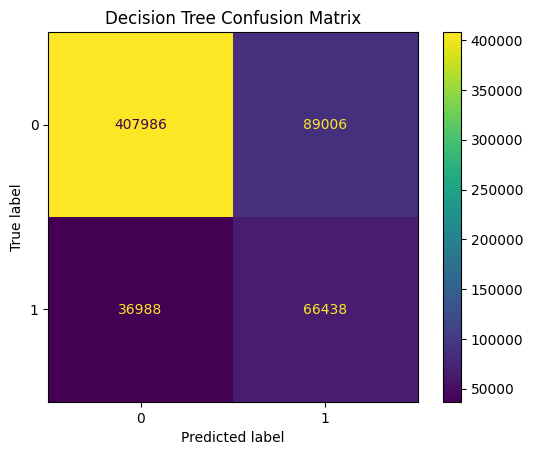


KNN Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84    496992
           1       0.30      0.38      0.33    103426

    accuracy                           0.74    600418
   macro avg       0.58      0.60      0.59    600418
weighted avg       0.77      0.74      0.75    600418



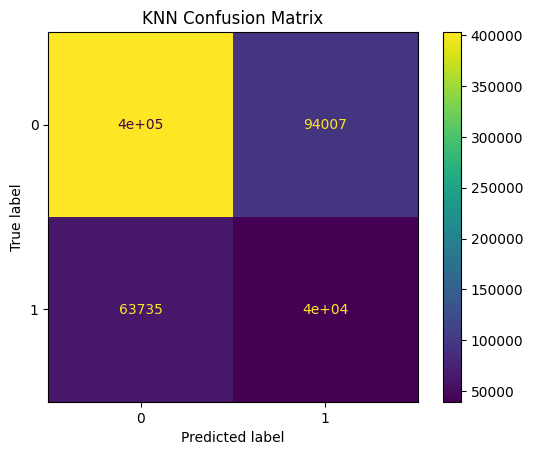

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:28:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94    496992
           1       0.86      0.53      0.66    103426

    accuracy                           0.90    600418
   macro avg       0.88      0.76      0.80    600418
weighted avg       0.90      0.90      0.90    600418



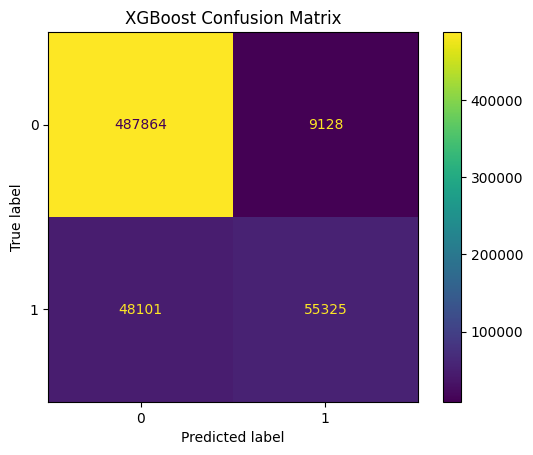

In [22]:
models_result(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



LogisticRegression Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.83      1.00      0.91    496992
           1       0.00      0.00      0.00    103426

    accuracy                           0.83    600418
   macro avg       0.41      0.50      0.45    600418
weighted avg       0.69      0.83      0.75    600418



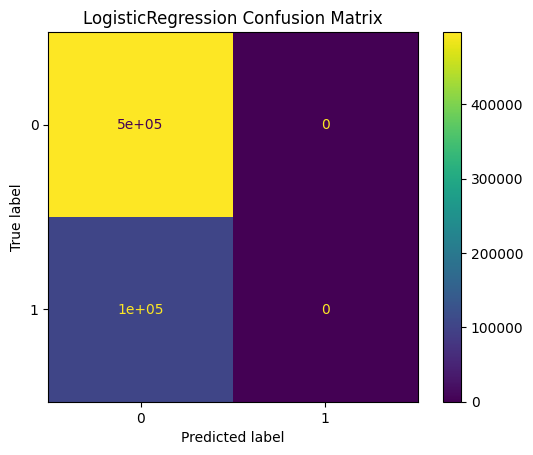


RandomForest Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88    496992
           1       0.34      0.17      0.23    103426

    accuracy                           0.80    600418
   macro avg       0.59      0.55      0.56    600418
weighted avg       0.76      0.80      0.77    600418



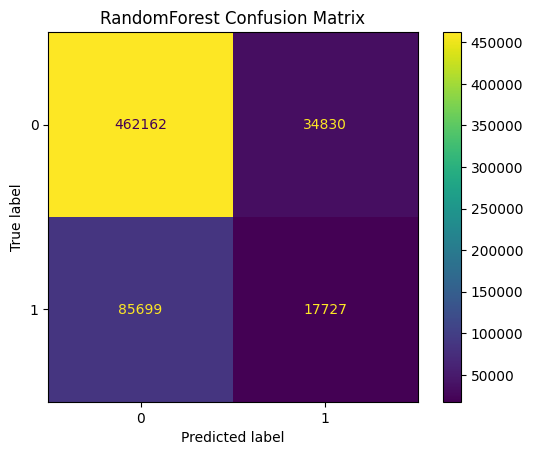


Decision Tree Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80    496992
           1       0.24      0.37      0.29    103426

    accuracy                           0.69    600418
   macro avg       0.55      0.56      0.55    600418
weighted avg       0.75      0.69      0.71    600418



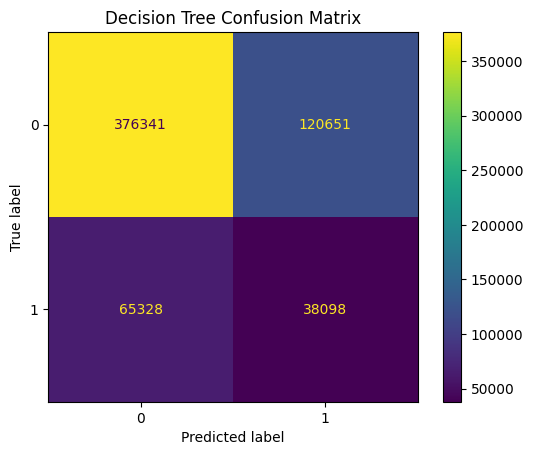


KNN Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84    496992
           1       0.30      0.38      0.33    103426

    accuracy                           0.74    600418
   macro avg       0.58      0.60      0.58    600418
weighted avg       0.77      0.74      0.75    600418



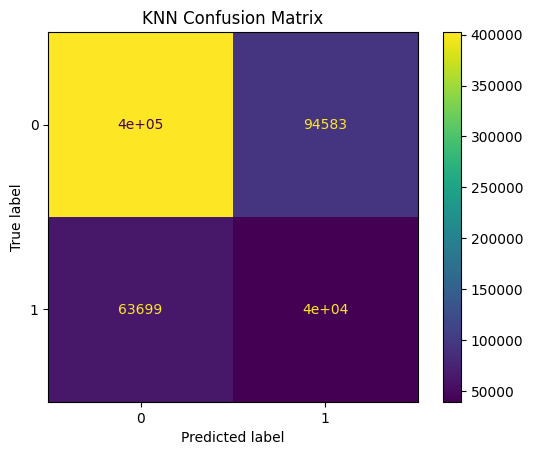

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:34:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89    496992
           1       0.35      0.14      0.20    103426

    accuracy                           0.81    600418
   macro avg       0.59      0.54      0.55    600418
weighted avg       0.76      0.81      0.77    600418



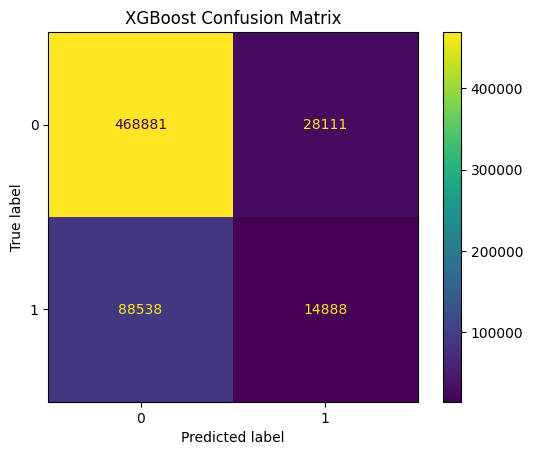

In [23]:
X_train2 = flights_2019.drop(columns=['DEL_15','DEP_TIME_BLK'])
X_test2 = flights_2020.drop(columns=['DEL_15', 'DEP_TIME_BLK'])
models_result(X_train2, X_test2, y_train, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre


LogisticRegression Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91    496992
           1       0.00      0.00      0.00    103426

    accuracy                           0.83    600418
   macro avg       0.41      0.50      0.45    600418
weighted avg       0.69      0.83      0.75    600418



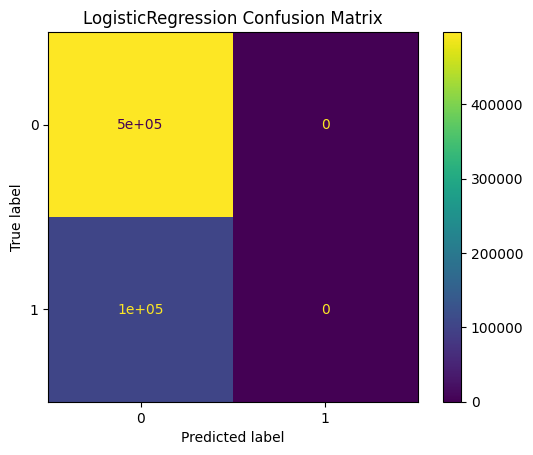


RandomForest Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87    496992
           1       0.24      0.14      0.18    103426

    accuracy                           0.78    600418
   macro avg       0.54      0.52      0.52    600418
weighted avg       0.73      0.78      0.75    600418



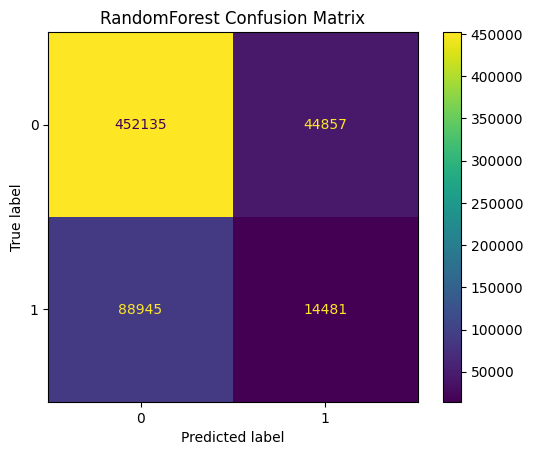


Decision Tree Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81    496992
           1       0.21      0.28      0.24    103426

    accuracy                           0.69    600418
   macro avg       0.52      0.53      0.52    600418
weighted avg       0.73      0.69      0.71    600418



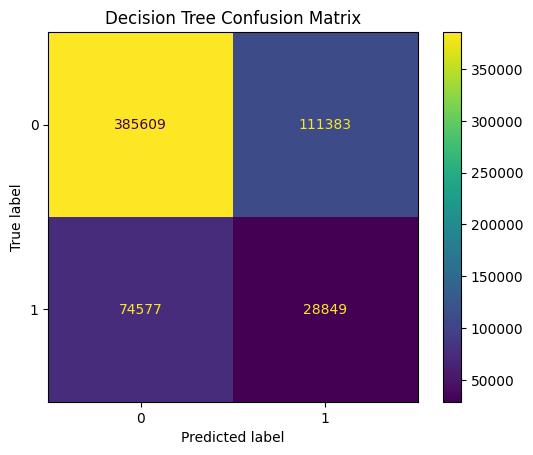


KNN Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.85    496992
           1       0.22      0.17      0.19    103426

    accuracy                           0.75    600418
   macro avg       0.53      0.52      0.52    600418
weighted avg       0.73      0.75      0.74    600418



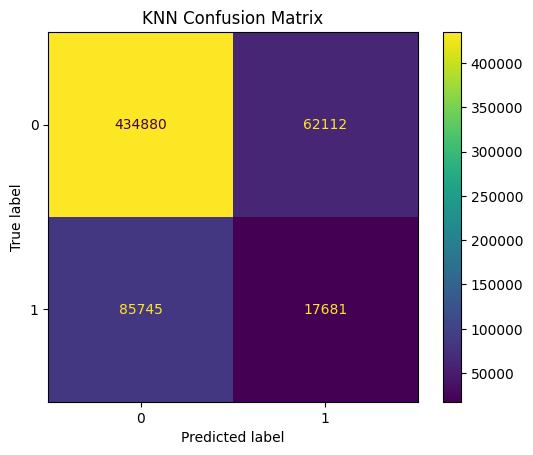

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:37:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89    496992
           1       0.27      0.09      0.14    103426

    accuracy                           0.80    600418
   macro avg       0.55      0.52      0.51    600418
weighted avg       0.74      0.80      0.76    600418



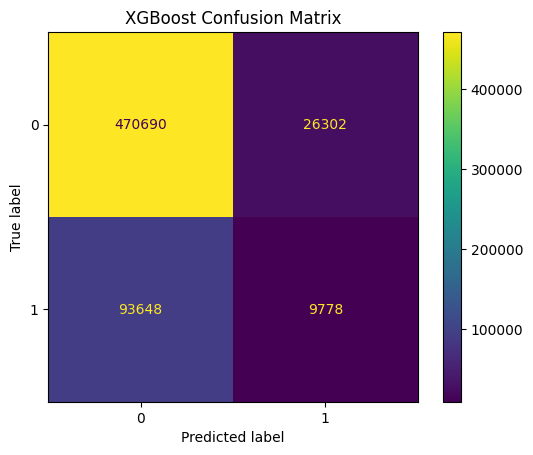

In [24]:
X_train3 = flights_2019.drop(columns=['DEL_15','DEP_TIME'])
X_test3 = flights_2020.drop(columns=['DEL_15', 'DEP_TIME'])
models_result(X_train3, X_test3, y_train, y_test)

In [ ]:
X_train4 = flights_2019.drop(columns=['DEL_15','DEP_TIME','DEP_TIME_BLK'])
X_test4 = flights_2020.drop(columns=['DEL_15', 'DEP_TIME', 'DEP_TIME_BLK'])
models_result(X_train4, X_test4, y_train, y_test)

In [ ]:
X_train5 = flights_2019.drop(columns=['DEL_15','DAY_OF_WEEK'])
X_test5 = flights_2020.drop(columns=['DEL_15', 'DAY_OF_WEEK'])
models_result(X_train5, X_test5, y_train, y_test)

In [ ]:
X_train6 = flights_2019.drop(columns=['DEL_15','DEST'])
X_test6 = flights_2020.drop(columns=['DEL_15', 'DEST'])
models_result(X_train6, X_test6, y_train, y_test)

In [ ]:
X_train7 = flights_2019.drop(columns=['DEL_15','ORIGIN'])
X_test7 = flights_2020.drop(columns=['DEL_15', 'ORIGIN'])
models_result(X_train7, X_test7, y_train, y_test)

In [ ]:
X_train8 = flights_2019.drop(columns=['DEL_15','DAY_OF_MONTH'])
X_test8 = flights_2020.drop(columns=['DEL_15', 'DAY_OF_MONTH'])
models_result(X_train8, X_test8, y_train, y_test)

In [ ]:
X_train9 = flights_2019.drop(columns=['DEL_15','OP_UNIQUE_CARRIER'])
X_test9 = flights_2020.drop(columns=['DEL_15', 'OP_UNIQUE_CARRIER'])
models_result(X_train9, X_test9, y_train, y_test)

In [ ]:
X_train10 = flights_2019.drop(columns=['DEL_15','DISTANCE'])
X_test10 = flights_2020.drop(columns=['DEL_15', 'DISTANCE'])
models_result(X_train10, X_test10, y_train, y_test)

In [ ]:
X_train11 = flights_2019.drop(columns=['DEL_15','DIVERTED'])
X_test11 = flights_2020.drop(columns=['DEL_15', 'DIVERTED'])
models_result(X_train11, X_test11, y_train, y_test)

The predictions seem too good to be true, specially in the logistic regression, I took all the features one by one hopping that one will change the results. Only when I took down OP_UNIQUE_CARRIER it slightly took the results down but in my opinion not enough to explain the results.

The best scores where obtained using the logistic regression model.